This project is based on the Kaggle copetition “Generative Dog Images”. The task is to generate upto 10,000 images in PNG format. The images should be 64x64 pixels and contain only dogs. The images will be evaluated based on the Frechet Inception Distance (FID) score. The lower the FID score, the better the generated images.

The dataset contains 20,579 images of dogs. The images are in JPG format and have varying sizes. The images are in the folder “all-dogs” and the corresponding annotations are in the file “annotation.csv”.

## What is a Generative Adversarial Network (GAN)?

Generative Adversarial Networks (GANs) are a class of deep learning models that are used to generate new data samples. GANs consist of two neural networks: a generator and a discriminator. The generator takes random noise as input and generates new data samples, while the discriminator takes real data samples and generated data samples as input and tries to distinguish between them. The generator and discriminator are trained in an adversarial manner, where the generator tries to fool the discriminator into thinking that the generated data samples are real, while the discriminator tries to correctly classify the data samples as real or generated.

## Initial setup
Import required libraries and check the path to the data files.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import warnings
warnings.filterwarnings('ignore')
print(os.listdir("../input"))

['Annotation.zip', 'all-dogs.zip']


In [2]:
!mkdir winput && cd ./winput && unzip -q ../../input/all-dogs.zip && unzip -q ../../input/Annotation.zip

mkdir: cannot create directory ‘winput’: File exists


## Data Structure and EDA (Exploratory Data Analysis) 

The dataset contains two main folders: “all-dogs” and “Annotation”. The “all-dogs” folder contains the images of dogs, while the “Annotation” folder contains the annotations for the images. The images are in JPG format and have varying sizes.
#### Check the number of images in the dataset

Total dogs pic count #20579.


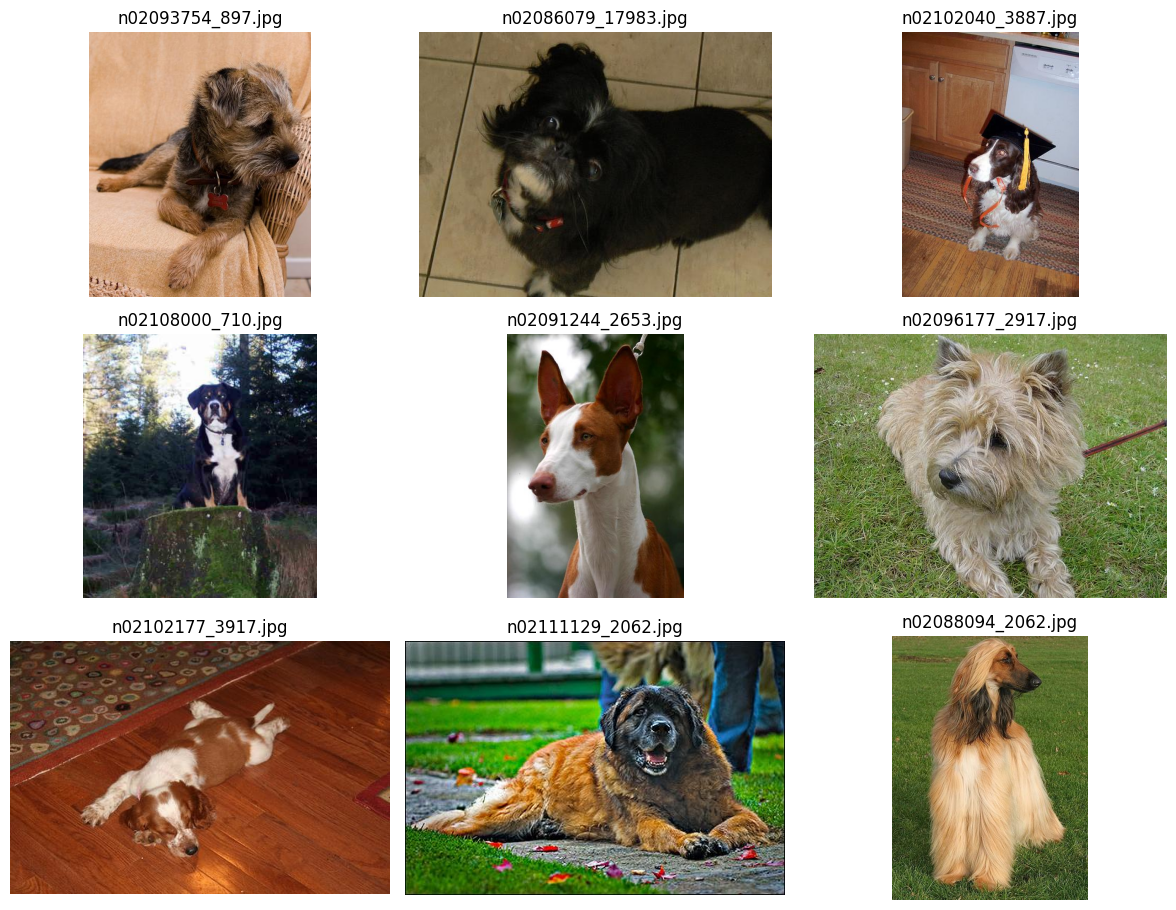

In [3]:
PATH = './winput/1/all-dogs/'
PATH_LIST = os.listdir(PATH)
print(f'Total dogs pic count #{len(os.listdir(PATH))}.')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH)))
    img = plt.imread(PATH + PATH_LIST[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(PATH_LIST[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#### Check the number of breeds in the dataset

In [4]:
from collections import defaultdict
by_breeds_dict = defaultdict(list)
for breed_code_and_pict_indx in PATH_LIST:
    breed_code, pict_indx = breed_code_and_pict_indx.split('_')
    by_breeds_dict[breed_code].append(pict_indx) 

Breeds count: 120


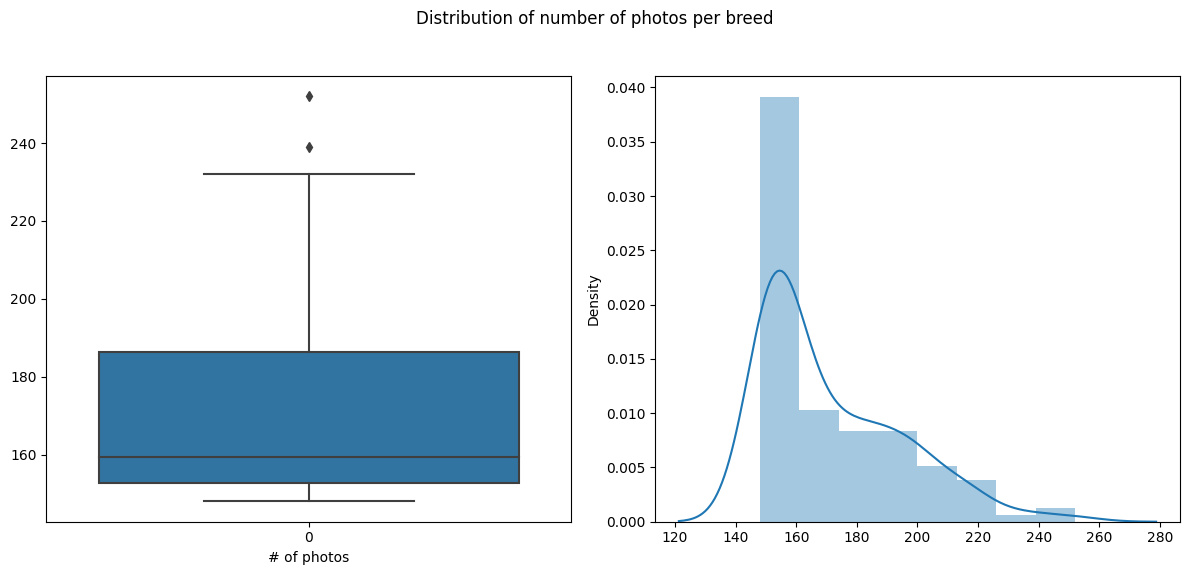

In [5]:
import seaborn as sns

df_aux = pd.DataFrame.from_dict(by_breeds_dict, orient='index').T
print(f'Breeds count: {df_aux.shape[1]}')

fig = plt.figure(figsize=(12, 6))
fig.suptitle('Distribution of number of photos per breed')
fig.add_subplot(121)
sns.boxplot(df_aux.shape[0] - df_aux.isnull().sum())
plt.xlabel('# of photos')
#plt.xticks([])
fig.add_subplot(122)
sns.distplot(df_aux.shape[0] - df_aux.isnull().sum())
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

As we can see, the dataset contains images of 120 breeds of dogs. The distribution of the number of images per breed is highly skewed, with some breeds having only a few images and others having many images. This imbalance in the dataset could pose a challenge for training a generative model that can generate images of all breeds of dogs.

#### Check the number of images per breed

Number of breeds with more than 100 images: 120


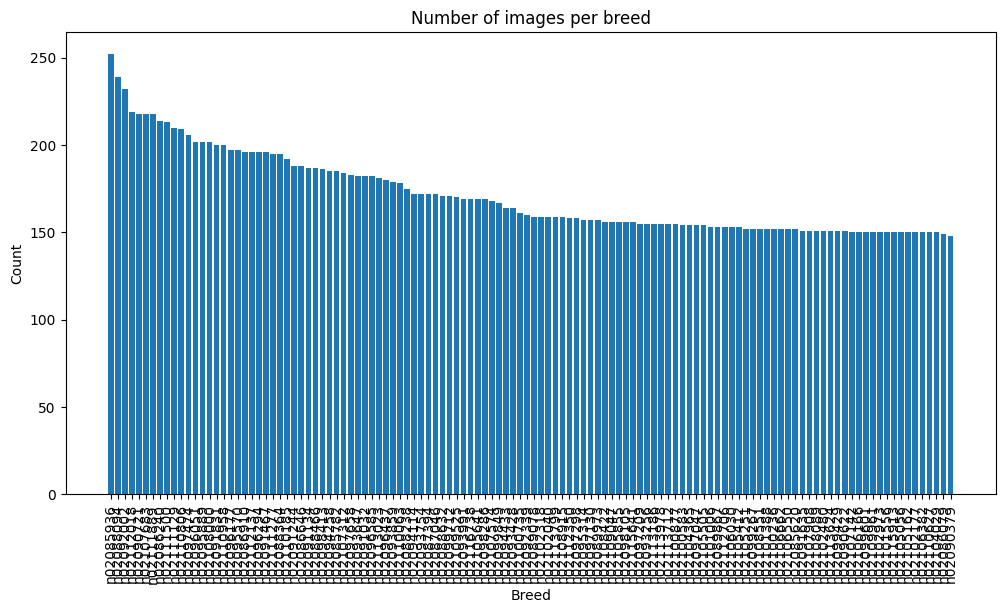

In [6]:
# Number of images per breed
breed_count = {}
for breed in by_breeds_dict:
    breed_count[breed] = len(by_breeds_dict[breed])
    
breed_count = dict(sorted(breed_count.items(), key=lambda x: x[1], reverse=True))
breed_count = {k: v for k, v in breed_count.items() if v > 100}
print(f'Number of breeds with more than 100 images: {len(breed_count)}')
plt.figure(figsize=(12, 6))
plt.bar(breed_count.keys(), breed_count.values())
plt.xticks(rotation=90)
plt.xlabel('Breed')
plt.ylabel('Count')
plt.title('Number of images per breed')
plt.show()

The bar chart shows the number of images per breed for the breeds with more than 100 images. The dataset contains a wide range of images per breed, with some breeds having more than 500 images and others having fewer than 100 images. This imbalance in the dataset could pose a challenge for training a generative model that can generate images of all breeds of dogs.

### Image transformations

The images in the dataset have varying sizes and aspect ratios. To train a generative model, we need to resize the images to a fixed size and convert them to a tensor. We will use the following transformations to preprocess the images:
- Resize the images to 64x64 pixels
- Center crop the images to 64x64 pixels
- Convert the images to a tensor
- Normalize the images with a mean of 0.5 and a standard deviation of 0.5
- Create a data loader to load the images in batches
- Define the generator and discriminator models
- Define the loss function and optimizer

In [7]:
batch_size = 32

transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# reads all data but only all-dogs are intended
train_data = datasets.ImageFolder('./winput/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)


In [8]:
class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels):
        super(Generator, self).__init__()
        self.conv1 = nn.ConvTranspose2d(nz, nfeats * 8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(nfeats * 8)
        
        self.conv2 = nn.ConvTranspose2d(nfeats * 8, nfeats * 8, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nfeats * 8)
        
        self.conv3 = nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        
        self.conv4 = nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(nfeats * 2)
        
        self.conv5 = nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(nfeats)
        
        self.conv6 = nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = torch.tanh(self.conv6(x))
        
        return x

In [9]:
class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
        
        self.conv2 = nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nfeats * 2)
        
        self.conv3 = nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
       
        self.conv4 = nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(nfeats * 8)
        
        self.conv5 = nn.Conv2d(nfeats * 8, 1, 4, 1, 0, bias=False)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))
        
        return x.view(-1, 1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 0.0003
beta1 = 0.5

netG = Generator(100, 32, 3).to(device)
netD = Discriminator(3, 48).to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

nz = 100
fixed_noise = torch.randn(25, nz, 1, 1, device=device)

real_label = 0.9
fake_label = 0
batch_size = train_loader.batch_size

### Training the GAN

The training loop for the GAN consists of two main steps: training the discriminator and training the generator. In the training loop, we alternate between training the discriminator and training the generator. The discriminator is trained to distinguish between real and fake images, while the generator is trained to generate images that fool the discriminator into thinking they are real.

The training loop consists of the following steps:
1. Train the discriminator with real images and real labels
2. Train the discriminator with fake images generated by the generator and fake labels
3. Calculate the loss for the discriminator and update the discriminator's weights
4. Train the generator with fake images and real labels
5. Calculate the loss for the generator and update the generator's weights
6. Repeat the process for a fixed number of epochs
7. Save the generator and discriminator models
8. Generate new images with the trained generator
9. Save the generated images to a zip file
10. Submit the generated images to the Kaggle competition

In [10]:
epochs = 2

step = 0
for epoch in range(epochs):
    for ii, (real_images, train_labels) in enumerate(train_loader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if step % 500 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
            valid_image = netG(fixed_noise)
        step += 1
        
        
# torch.save(netG.state_dict(), 'generator.pth')
# torch.save(netD.state_dict(), 'discriminator.pth')

[1/2][0/644] Loss_D: 1.4947 Loss_G: 3.8572 D(x): 0.5137 D(G(z)): 0.5494 / 0.0144
[1/2][500/644] Loss_D: 1.0366 Loss_G: 1.8664 D(x): 0.4585 D(G(z)): 0.1432 / 0.1574
[2/2][356/644] Loss_D: 1.2652 Loss_G: 2.6775 D(x): 0.7965 D(G(z)): 0.5471 / 0.0587


### Generate images and save to zip file

The trained generator model is used to generate new images of dogs. The images are saved to a zip file and submitted to the Kaggle competition.

In [11]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/home/jupyter/work/images.zip'